(788, 2)
0
1
2
3
4
5
6
7
8
save ok


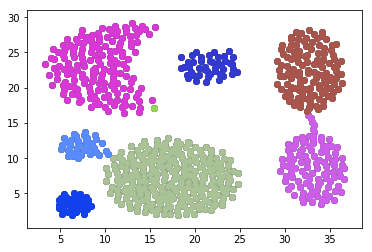

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.nonparametric.api as smnp
import math
import copy
from sklearn.cluster import DBSCAN
#from skimage import exposure,data
from pandas import Series, DataFrame
import random
from collections import Counter
from itertools import permutations, combinations
dataSet = np.loadtxt('788points.txt')
#dataSet = np.loadtxt('two_clusterx.txt')
#dataSet = np.loadtxt('julei1.txt')
#dataSet = np.loadtxt('spiral.txt')
print(dataSet.shape)
plt.scatter(dataSet[:,0],dataSet[:,1],color='black',label='aa')
#plt.show()
dist_List=[]
def randomcolor():
    colorArr = ['1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
    color = ""
    for i in range(6):
        color += colorArr[random.randint(0,14)]
    return "#"+color
def dist(a,b):
    """
    :param a: 样本点
    :param b: 样本点
    :return: 两个样本点之间的欧式距离
    """
    return math.sqrt(math.pow(a[0]-b[0],2) + math.pow(a[1]-b[1],2)) 
def CalculateDistMatrix(dataset):
    """
    :param dataset: 数据集
    :return: 距离矩阵
    """
    DistMatrix = [[0 for j in range(len(dataset))] for i in range(len(dataset))]
    #Dist_List = []
    for i in range(len(dataset)):
        for j in range(len(dataset)):
            DistMatrix[i][j] = dist(dataset[i], dataset[j])
            dist_List.append(DistMatrix[i][j])
    return DistMatrix
def Dist_All_Calculater():
    #首先最好计算出所有点的距离，这样能够有效的避免重复计算增加的复杂度
    Dist_List = CalculateDistMatrix(dataSet)
    Dist_array = np.array(Dist_List)
    return Dist_array
#计算随机点的距离 形成距离矩阵
def append_random_Dist(rand_int):
    DistMatrix = [[0 for j in range(len(rand_int))] for i in range(len(rand_int))]
    #Dist_List = []
    for i in range(len(rand_int)):
        for j in range(len(rand_int)):
            DistMatrix[i][j] = DistArray_All[rand_int[i]][rand_int[j]]
            #Dist_List.append(DistArray_All[rand_int[i]][rand_int[j]])
    return DistMatrix
def kde_test(data, kernel, bw, gridsize, cut):
    fft = kernel == "gau"
    kde = smnp.KDEUnivariate(data)
    kde.fit(kernel, bw, fft, gridsize=gridsize, cut=cut)
    return kde.support, kde.density
def gradient_kde(datax,datay):
    min_gra = []#鞍部
    max_gra=[]#第一个波峰
    max_gra_second=[]#第二个波峰
    maxList=[]
    minList=[]
    for i in range(len(datax)-2):
        gradient1 = (datay[i+1]-datay[i])/(datax[i+1]-datax[i])
        gradient2 = (datay[i+2]-datay[i+1])/(datax[i+2]-datax[i+1])
        if((gradient1>=0)&(gradient2<=0)):
            max_single=[]
            max_single.append(datax[i+1])
            max_single.append(datay[i+1])
            maxList.append(max_single)
        if((gradient1<=0)&(gradient2>=0)):
            min_single=[]
            min_single.append(datax[i+1])
            min_single.append(datay[i+1])
            minList.append(min_single)
    max_gra=maxList[0]
    maxList.remove(maxList[0])
    maxList = sorted(maxList,key=lambda x:x[1],reverse=True)
    max_gra_second=maxList[0]
    index_max=max_gra_second[1]
    now_min=index_max
    for n in minList:
        if((index_max-n[1])<=0):
            continue
        else:
            if((index_max-n[1])<now_min):
                now_min=(index_max-n[1])
                min_gra=n
    #取最高的两峰和中间的一峰
    return min_gra[0],max_gra[0],max_gra_second[0]
def draw_plot2(data,kernel,bw,gridsize,cut):
    kdefit_x, kdefit_y = kde_test(data,kernel,bw,gridsize=gridsize,cut=cut)
    #plt.plot(kdefit_x, kdefit_y,color='k',label='sads')
    #plt.show()
    #寻找鞍部
    #寻找类内峰值
    min_gra,max_gra,max_gra_second = gradient_kde(kdefit_x,kdefit_y)
    return min_gra,max_gra,max_gra_second
def kde_All():
    kernel='gau'
    bw="scott"
    gridsize = 60
    cut = 2
    max_dist,middle_dist,sencond_maxdist = draw_plot2(dist_List,kernel,bw,gridsize,cut)
    return max_dist,middle_dist,sencond_maxdist
def gradient_set2(datalist):
    #方案1:最高峰值，前面的是
    max_index=0
    max_outindex=0
    #max_gradient =datalist[1]-datalist[0]
    max_gradient =0
    #gradient=[]
    for i in range(len(datalist)-5):
        gradient_single = datalist[i+1]-datalist[i]
        #gradient.append(gradient_single)
        if(gradient_single>max_gradient):
            if((i>5)):
                max_gradient=gradient_single
                max_index=i
                max_outindex=i+1
    #plt.plot(gradient)
    #plt.show()
    #print(max_index)
    return max_index,max_outindex
def entry(datalist):
    #先对这一行的距离排序
    datalist = sorted(datalist,reverse=False)
    #plt.plot(datalist)
    #plt.show()
    #然后计算其斜率
    max_index,max_outindex = gradient_set2(datalist)
    fast_dist = datalist[max_index]
    outfast_dist=datalist[max_outindex]
    #average_a = np.mean(outcluster_dist)
    return fast_dist,outfast_dist
def find_Minpts(index,epts):
    datalist = DistArray_All[index].tolist()
    datalist = sorted(datalist,reverse=False)
    average_index=0
    for i in range(len(datalist)):
        if(datalist[i]>epts):
            average_index = i-1
            break
    return average_index
def set_group(list_a):
    tgt = []
    # 遍历所有元素，进行分组
    for i, x in enumerate(list_a):
        z = x  # 暂存当前元素
        flag = []  #
        # 如果目标库不为空，遍历目标库，看是否存在有交集的元素
        if len(tgt) > 0:
            for j, y in enumerate(tgt):
                # 判断是否存在交集
                if z.intersection(y):
                    z = z.union(y)
                    # 若存在并集，则将当前元素记录
                    flag.append(j)
                    # 如果存在已有的元素，删除原有的元素
            if len(flag) > 0:
                flag.reverse()  # 之所以要倒排一下，是防止list删除元素后的遍历异常
                for k in flag:
                    tgt.pop(k)
        tgt.append(z)
    return tgt
def findNeighbor(i,point_list,eps):
    neighborlist=[]
    sumDist=0
    n=0
    average=0
    while(n<len(point_list)):
        if(DistArray_All[i][point_list[n]]<eps):
            neighborlist.append(point_list[n])
            sumDist+=DistArray_All[i][point_list[n]]
        n+=1
    if len(neighborlist)>0:
        average = sumDist/len(neighborlist)
    return neighborlist,average
def randomSet(max_dist,middle_dist,second_maxdist):
    shape = dataSet.shape[0]
    info_lists = [[0 for j in range(4)] for i in range(shape)]
    point_list = [0 for i in range(shape)]
    n=0
    clusterCenter=[]#存放所有疑似中心点的集合
    for i in range(shape):
        info_lists[i][0]=i #原始的序号
        info_lists[i][1]=-1 #表示没有被聚类
        dist_list=DistArray_All[i].tolist() #代表该点到其他点的距离
        eptsDist,outDist=entry(dist_list) #求出关键的参数
        info_lists[i][2]=outDist #类内最大距离
        x1=abs(max_dist-outDist) #中心点指标1
        x2=abs(middle_dist-eptsDist) #中心点指标2
        info_lists[i][3]=x2+x1 #指标按照1+2计算
    #排序 按照指标由小到大排序
    info_lists = sorted(info_lists,key=lambda x:x[3],reverse=False)
    for i in range(len(info_lists)):
        point_list[i]=info_lists[i][0] #没有访问的节点
    #开始聚类
    #时间复杂度O(LogN)
    clusters=[]
    cluster_centers=[]
    cluster_averageIndex=[]
    while(len(point_list)>0):
        point_now_cluster=[]#当前类中已经访问的点,保存每个类都有谁
        i = point_list[0]#这个点是类的起始点
        #计算eps就行
        data = [data for data in info_lists if data[0]==i]
        eps = data[0][2]#eps是类内两点间的平均距离
        point_list.remove(i)
        point_now_cluster.append(i)
        NeighborPts,avergae=findNeighbor(i,point_list,eps)
        for m in NeighborPts:
            point_list.remove(m)
            point_now_cluster.append(m)
        if(len(point_now_cluster)>3):
            clusters.append(point_now_cluster)
            cluster_centers.append(i)
            cluster_averageIndex.append(avergae)
        else:
            print(dataSet[point_now_cluster])
    indexofcluster=0
    originallList = [0 for i in range(shape)]
    #print(originallList)
    for m in clusters:
        print(indexofcluster)
        randint_scatterxy1 = []
        colorrr = randomcolor()
        for n in m:
            randint_scatterxy1.append(dataSet[n].tolist())
           # print(n)
            originallList[n]=indexofcluster
            #print(indexofcluster)
        scatter = np.array(randint_scatterxy1)
        plt.scatter(scatter[:,0],scatter[:,1],color=colorrr,label='aa')
        indexofcluster=indexofcluster+1
    n=0
    n=len(clusters)
    print(n)
    #print(originallList)
    np.savetxt('788points_result.txt',originallList,fmt="%d")
    print('save ok')
    plt.show()
DistArray_All = Dist_All_Calculater()
#通过kde获取到大概的范围
max_dist,middle_dist,second_maxdist = kde_All()
randomSet(max_dist,middle_dist,second_maxdist)